In [1]:
import numpy as np
from scipy.stats import multivariate_normal
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [2]:
# Data Preprocessing
TRAIN = './mnist_train.csv'
TEST = './mnist_test.csv'

# Function to load data and split into features and labels
def load_data_and_split(filepath):
    data = np.genfromtxt(filepath, delimiter=',', skip_header=1, dtype='int')
    X = data[:, 1:]  # All columns except the first one
    y = data[:, 0]  # Only the first column
    return X, y

# Load and split the training and testing data
X_train, y_train = load_data_and_split(TRAIN)
X_test, y_test = load_data_and_split(TEST)

# Normalize the training and testing data
X_train = X_train.astype(np.float64)
X_test = X_test.astype(np.float64)

X_train /= 255
X_test /= 255

In [3]:
class GaussianNaiveBayes:
    def __init__(self):
        self._mu = dict()
        self._sigma = dict()
        self._pi = dict()
        
    def fit(self, X, y, smoothing=0):
        self._classes = np.unique(y)
        self.n_classes = len(self._classes)
        
        cov = np.diag(np.diag(np.cov(X, rowvar=False)))
        max_var = np.max(cov)
        # Compute mean, var, and prior for each class
        for idx, c in enumerate(self._classes):
            X_c = X[y == c]
            self._mu[idx] = X_c.mean(axis=0)
            self._sigma[idx] = np.diag(np.diag(np.cov(X_c, rowvar=False))) + smoothing*max_var
            self._pi[idx] = X_c.shape[0] / X.shape[0]


    def predict(self, X):
        # Compute posterior probability for each class
        n_samples, n_features = X.shape
        preds = np.zeros((n_samples, self.n_classes), dtype=np.float64)
        
        for idx, c in enumerate(self._classes):
            prior = np.log(self._pi[idx])
            class_conditional = self._pdf(idx, X)
            posterior = prior + class_conditional
            preds[:, idx] = posterior
        # Return the class with the highest posterior probability
        return self._classes[preds.argmax(axis=1)]


    def _pdf(self, class_idx, X):
        mean = self._mu[class_idx]
        sigma = self._sigma[class_idx]
        pdf_values = multivariate_normal.logpdf(X,mean=mean, cov=sigma, allow_singular=True)
        return pdf_values

0.001
Accuracy: 78.880%
One-Zero Error: 21.120%
0.01
Accuracy: 78.880%
One-Zero Error: 21.120%
0.1
Accuracy: 78.380%
One-Zero Error: 21.620%
1
Accuracy: 79.800%
One-Zero Error: 20.200%
10
Accuracy: 80.800%
One-Zero Error: 19.200%
100
Accuracy: 79.140%
One-Zero Error: 20.860%


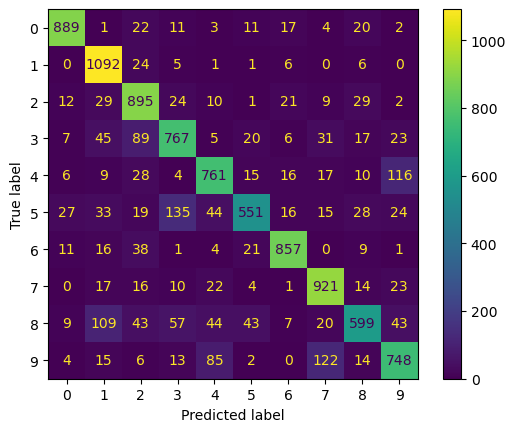

In [4]:
# Initialize Gaussian Naive Bayes classifier
gnb = GaussianNaiveBayes()

smoothing =  [0.001, 0.01, 0.1, 1, 10, 100]
accuracy = []
y_preds = dict()

for idx, s in enumerate(smoothing):
    
    # Fit the model on the training data
    gnb.fit(X_train, y_train, smoothing=s)

    # Predict on test data
    y_pred = gnb.predict(X_test)
    y_preds[idx] = y_pred
    
    # Calculate accuracy
    acc = np.mean(y_pred == y_test)
    accuracy.append(acc)
    print(s)
    print(f"Accuracy: {acc * 100:.3f}%")
    print(f"One-Zero Error: {(1-acc)*100 :.3f}%")

y_pred = y_preds[accuracy.index(max(accuracy))]

# Plot confusion matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()
